Ova sveska uvodi Keras biblioteku i ilustruje njene osnovne koncepte. Zadatak na kojem ćemo raditi je kreiranje neuronske mreže sa propagacijom unapred (engl. feed forward neural network) koja se može iskoristiti u zadatku binarne klasifikacije pacijenata na one sa i bez dijabetesa. Stari problem, ali sa novim pristupom rešavanja. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
np.random.seed(7)

### Keras biblioteka

[Keras](https://keras.io/) je popularna biblioteka koja nudi podršku u radu sa dubokim neuronskim mrežama. Na njenom razvoju radi Google tim, a zajednica koja je koristi je mnogobrojna. Da bismo mogli da je koristimo u okviru Anaconda okruženja, potrebno ju je instalirati komandom `conda install -c conda-forge keras` u skladu sa [zvaničnim smernicama](https://anaconda.org/conda-forge/keras). Kako je njen API visokog nivoa, u pozadini, na niskom nivou, se može koristiti Tensor Flow, Theano ili CNTK (tzv. backend deo biblioteke). Cilj pobrojanih biblioteka je da pokriju zadatke poput efikasnih algebarskih operacija i numeričog difrerenciranja ili paralelilazija jer rad sa neuronskim mrežama obično podrazumeva i rad sa velikom količinom podataka. U našem radu će to biti Tensor Flow pa je potrebno osigurati se da je i on instaliran. Više o instalaciji Tensor Flow biblioteke možete pročitati [ovde](https://anaconda.org/conda-forge/tensorflow).   

Keras podržava dve vrste API-ja, `standardni` koji ćemo upoznati u primerima koji slede i `funkcionalni` koji daje nešto više fleksibilnosti za nadgradnje biblioteke. Njega ćemo upoznati u priči o konvolutivnim neuronskim mrežama.

In [3]:
import tensorflow as tf
from tensorflow import keras

Za sada ćemo učitati funkcije `Sequential` i `Dense` čije ćemo značenje pojasniti u nastavku.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

### Skup podataka - Pima Indians Diabetes

Skup podataka "Pima Indians Diabetes" se sastoji od 768 instanci. Svaka instanca sadrži vrednosti 8 medicinski relevantnih vrednosti i pridružena joj je klasa 1 ili 0 u zavisnosti od toga da li je pacijentu u poslednjih 5 godina dijagnostifikovan dijabetes  ili ne. 

Svi atributi su numeričkog tipa sa opsegom vrednosti koji varira od atributa do atributa. 

Skup podataka se može preuzeti sa [ove](https://www.kaggle.com/uciml/pima-indians-diabetes-database#diabetes.csv) adrese.

In [5]:
data = pd.read_csv('data/pima_indians_diabetes.csv')

In [6]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
data.shape

(768, 9)

In [8]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Naš cilj je da napravimo model koji će na osnovu pomenutih atributa vršiti predikciju da li pacijentkinja boluje od dijabetesa ili ne.

### Korak 1: Priprema skupa podataka

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
y = data['Outcome']
X = data.drop(columns=['Outcome'])

Podatke ćemo uobičajeno podeliti funkcijom `train_test_split` biblioteke `scikit-learn`. Prilikom podele skupa podataka vodićemo računa o stratifikaciji. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [12]:
print('Skup za treniranje - X: {0}, y: {1}'.format(X_train.shape, y_train.shape))

Skup za treniranje - X: (614, 8), y: (614,)


In [13]:
print('Skup za testiranje - X: {0}, y: {1}'.format(X_test.shape, y_test.shape))

Skup za testiranje - X: (154, 8), y: (154,)


Podatke ćemo zbog numeričke stabilnosti mreže kao i do sada standardizovati.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Korak 2: Kreiranje mreže

Mrežu ćemo napraviti tako da njena arhitektura zadovoljava sledeće specifikacije:

* **Sloj 1**: potpuno povezani sloj sa 15 neurona i *ReLu* aktivacionom funkcijom 
* **Sloj 2**: potpuno povezani sloj sa 8 neurona i *ReLu* aktivacionom funkcijom
* **Sloj 3**: potpuno povezani sloj sa jednim neuronom i *sigmoidnom* aktivacionom funkcijom


Neuronska mreža sa propagacijom unapred kreira se funkcijom `Sequential`. Na ovaj način naglašavamo da ćemo slojeve mreže dodavati jedan za drugim, povezivajući izlaze prethodnog sloja sa ulazima narednog sloja.

In [15]:
model = Sequential()

Mreža se sastoji od pojedinačnih slojeva. Možemo reći da su slojevi moduli koji obrađuju podatke i da za zadate ulaze generišu odgovarajuće izlaze. Razlikujemo ulazni, prvi, sloj mreže, izlazni, poslednji, sloj mreže i slojeve između koje nazivamo skrivenim slojevima. <img src='assets/layers.png'> Slojeve karakteriše matrica koeficijenata čije optimalne vrednosti mreža u toku treniranja treba da nauči. Samu matricu koeficijenata zovemo `kernel` matricom. Njene vrednosti se mogu nasumično inicijalizovati, ali se u praksi obično koriste neke bolje tehnike inicijalizacije koje dovode do boljeg treniranja mreže. Trenutno najpoznatije su Gloriot (ili Xaviar) i He, obe nazvane po imenima autora. 

Ulazni, prvi sloj mreže, možemo kreirati pozivom funkcije `Input`. Njen argument `shape` ukazuje na dimenziju ulaza, pa ćemo stoga postaviti da je njegova vrednost `(8, )` jer skup sa kojim radimo ima 8 atributa. Druga dimenzija para je fleksibilna i prilikom treniranja mreže prilagođavaće se veličini paketića koji se koristi. Na nivou Keras biblioteke, pojedinačni slojevi mreže dodaju se funkcijom `add`.

In [16]:
model.add(Input(shape=(8,)))

Potpuno povezani sloj (engl. fully connected layer), kao što ime kaže, povezuju svaki čvor, neuron, ulaznog sloja sa svakim čvorom, neuronom, izlaznog sloja. Funkcija koju izračunava može se opisati formulom `output = activation(dot(input, kernel) + bias)` gde  `kernel` predstavlja matricu sloja, `bias` vektor njegovih slobodnih članova, `dot` matrično množenje, a `activation` aktivacionu funkciju koja se koristi na nivo sloja. 
<img src='assets/fully_connected_layer_2.png' style='width: 300px'>

Potpuno povezani sloj (koji se naziva i gusti sloj) kreiramo funkcijom `Dense`. Kroz parametar `units`, čije se ime često i izostavlja jer se novodi prvi u pozivu funkcije, navodi se broj izlaznih neurona. Biblioteka podrazumevano izlaze prethodnih slojeva uparuje sa ulazima narednih slojeva pa nije neophodno navoditi dimenziju ulaza. Za to se inače može koristiti atribut `input_dim`. Ime aktivacione funkcije se navodi parametrom `activation` i to mogu biti sigmoidna funkcija, hiperbolički tanges, linearna funkcija, ReLu, softmax i još neke druge. Ostalim parametrima funkcije `Dense` može se uticati na način inicijalizovanja kernel matrice i vektora slobodnih članova koji se podrazumevano dodaje, kao i na njihove regularizacije.

Prateći specifikaciju arhitekture, možemo dodati zahtevane slojeve. 

In [17]:
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

Opis mreže po slojevima se može dobiti funkcijom `summary`. Ona nam daje uvid i u ukupan broj parametara mreže koje treba naučiti. 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                135       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


Prokomentarišimo kratko da dobijene vrednosti odražavaju prisustvo slobodnog člana u svakom sloju mreže kada je u ulazi ulaznog sloja (135 = 8x15 + 1x15, 128 = 15x8 + 1x8, 9 = 8x1 + 1x1).  

Korak zadavanja ulaznog sloja funkcijom `Input` i korak zadavanja prvog gustog sloja funkcijom `Dense` je u praksi moguće objediniti dodavanjem parametar `input_dim` prvom gustom sloju kojim se zadaje dimenzija ulaza. Tako se u prethodnom bloku koda umesto linija 

`model.add(Input(shape=(8,)))
model.add(Dense(units=15, activation='relu'))
`

mogla navesti linija `model.add(Dense(units=15, input_dim=8, activation='relu'))`. 
Prvi način je ipak čitljiviji i predstavlja novinu koja je uvedena sa novijom verzijom Keras biblioteke.


### Korak 3: Treniranje mreže

Da bismo mogli da traniramo mrežu, neophodno je da se opredelimo za funkciju gubitka koja pristaje zadatku i odgovarajući optimizator. Funkcija gubitka (engl. loss function) izračunava koliko dobro mreža predviđa ono što se od nje očekuje i generiše povratni signal neophodan za samo učenje. Optimizator dalje na osnovu ovako dobijenih vrednosti ažurira vrednosti parametara mreže. Cilj treniranja mreže je minimizovati funkciju gubitka uz očuvanje dobre generalizacije. 
<img src='assets/training_steps.png'>

Mrežu ćemo trenirati prema sledećim smernicama:
    
* **Funkcija greške**: binarna unakrsna entropija (engl. binary cross entropy)

* **Optimizator**: Adam

* **Broj epoha**: 50
* **Veličina paketića za treniranje (engl. batch size)**: 32

Funkcija `compile` se koristi za pridruživanje modelu funkcije gubitka, optimizatora i, opciono, metrike koja će se koristiti za evaluaciju mreže.

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Prilikom treniranja, mreži se prosleđuju takozvani `batch` paketići podataka. Nakon svakog obrađenog paketića, izračunava se vrednost funkcije gubitka, a potom i ažuriraju parametri mreže. Epoha predstavlja jedan prolazak kroz ceo skup podataka.  

Funkcijom `fit` se trenira sama mreža. Ona očekuje podatke za treniranje, broj epoha (parametar `epochs`) i veličinu paketića podataka (parametar `batch_size`). Objekat tipa `History` koji se dobija kao rezultat poziva ove funkcije sadrži vrednosti funkcije gubitka i odabrane metrike na kraju svake epohe koje se, dalje, mogu koristiti za praćenje procesa treniranja. Ove vrednosti se nalaze u rečniku sa imenom `history`.

In [20]:
history = model.fit(X_train, y_train, epochs= 50, batch_size= 32, verbose = 0)

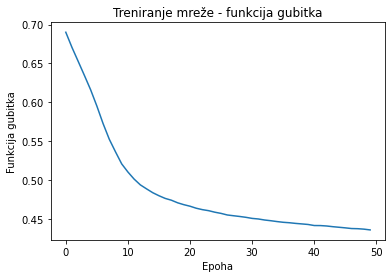

In [21]:
plt.title('Treniranje mreže - funkcija gubitka')
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.plot(history.epoch, history.history['loss'])
plt.show()

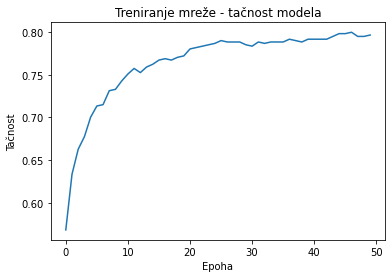

In [22]:
plt.title('Treniranje mreže - tačnost modela')
plt.xlabel('Epoha')
plt.ylabel('Tačnost')
plt.plot(history.epoch, history.history['accuracy'])
plt.show()

Na primer, na osnovu prvog grafika mogu se izvesti neke intuicije o optimizaciji, veličini koraka učenja i brzini konvergencije. Sledeća slika sumira zaključke i iskustva.  <img src='assets/loss_monitoring.png'>

U sledećem primeru, nakon uvođenja validacionog skupa, diskutovaćemo još neke analize.

### Korak 4: Evaluacija mreže

Da bismo mogli da ocenimo uspešnost treniranja mreže, potrebne su nam vrednosti relevantnih metrika na skupu za testiranje. I u slučaju neuronskih mreža, baš kao i do sada, prilikom evaluacije modela vodimo računa da ni u jednom trenutku ne dođe do preklapanja skupa za treniranje i skupa za testiranje. Evaluacija modela se radi propuštanjem paketića skupa za testiranje kroz mrežu, beleženjem i uprosečavanjem dobijenih vrednosti.

U našem slučaju, za zadatak klasifikacije, koristili smo kao metriku tačnost.

In [23]:
model.metrics_names

['loss', 'accuracy']

Funkcija `evaluate` biblioteke Keras nam omogućava da sprovedemo opisanu proceduru. Njen rezultat je niz koji sadrži izračunate vrednosti za svaku od metrika navedenih u `model.metrics_names` nizu.

In [24]:
test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Skup za testiranje {0}: {1}'.format(model.metrics_names[1], test_scores[1]))

5/5 [==============================] - 0s 2ms/step - loss: 0.4618 - accuracy: 0.7662
Skup za testiranje accuracy: 0.7662337422370911


Da bi se pratilo preprilagođavanje mreže, obično se relevantne metrike računaju i na skupu za treniranje.

In [25]:
train_scores = model.evaluate(X_train,y_train)
print('Skup za treniranje {0}: {1}'.format(model.metrics_names[1], train_scores[1]))

20/20 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7997
Skup za treniranje accuracy: 0.7996742725372314


Nasumična podela skupa podataka na skup za treniranje i skup za testiranje i kod neuronskih mreža, baš kao i kod drugih modela, može prouzrokovati neobjektivnost ocena. Unakrsnu validaciju je moguće realizovati podelom skupa podataka na grupe funkcijom `KFold` i praćenjem dobijenih vrednosti. Ovde ćemo jednostavnosti radi upoznati omotač `KerasClassifier` koji omogućava unakrsnu validaciju Keras modela u duhu biblioteke `scikit-learn`.  

In [26]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [27]:
def baseline_model():
    model = Sequential()
    model.add(Dense(units=15, input_dim=8, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

Funkcija KerasClassifier očekuje model koji treba pokrenuti, broj epoha i veličinu paketića.

In [28]:
classifier = KerasClassifier(build_fn=baseline_model, nb_epoch=50, batch_size=32, verbose=0)

In [29]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', classifier)])

In [ ]:
accuracy_scores = model_selection.cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

In [31]:
accuracy_scores

array([0.68831169, 0.57792208, 0.54545455, 0.43137255, 0.47058824])

In [32]:
np.average(accuracy_scores)

0.5427298192004075

U radu sa velikim skupovima podataka, zbog vremenske zahtevnosti, ne uzimaju se velike vrednosti `cv` parametra, a vrlo često se ovaj vid evaluacije i preskače.

### Korak 5: Korišćenje mreže

Za predikciju vrednosti modela može se koristiti funkcija `predict`.

In [33]:
number_of_features = X_train.shape[1]

In [34]:
x_new = np.random.random(number_of_features)
x_new = scaler.transform(x_new.reshape(1, -1))

Vrednost koju naša mreža predviđa je vrednost sigmoidne funkcije poslednjeg sloja pa da bi odredili da li nova instanca pripada klasi ili ne treba uporediti njenu vrednost sa 0.5.

In [35]:
y_new_sigmoid = model.predict(x_new)

In [36]:
y_new = 0 if y_new_sigmoid<0.5 else 1

In [37]:
y_new

0

Još jedan, za nijansu komaptniji, način koji omogućava očitavanje predikcije je uz korišćenje funkcije `argmax`.

In [38]:
np.argmax(model.predict(x_new), axis=-1)

array([0])

U praksi se optimalna arhitektura mreže tj. broj slojeva, broj neurona po slojevima, odgovarajuće aktivacione funkcije, broj epoha treniranja i slično određuju kao i do sada pominjani hiperparametri. O tome će biti više reči u nastavku. 

<div class="alert alert-info">
Za vežbu:

<ul>
    <li>Isprobati različite aktivacione funkcije u slojevima, na primer, sigmoidnu i hiperbolički tanges</li>
    <li>Isprobati nešto drugačije arhitekture mreže</li>
    <li>Uporediti rezultate treniranja mreže kada se poveća/smanji broj epoha treniranja</li>
</ul>
</div>